<a href="https://colab.research.google.com/github/mart-anthony-stark/Machine-Learning-and-Deep-Learning/blob/main/Fake_News_Detection_PH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection PH
Dataset: https://huggingface.co/datasets/fake_news_filipino

Task: text-classification NLP

Contains 3,206 expertly-labeled news samples, half of which are real and half of which are fake.

In [168]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import missingno
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


# Data Exploration

In [80]:
df = pd.read_csv('fakenews_data_ph.csv')

In [81]:
df.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [82]:
df.tail()

,label,article
3201,1,Hindi pa nai-enjoy ni Giacomo Filibeck ang Pil...
3202,1,"Sa isang pahayag, binatikos ng Liberal Party (..."
3203,1,Panoorin nyo yung reaction video na ito ni Mr....
3204,1,Para sa mga magkakapatid na laging nagtatalo l...
3205,1,Grabe ibang klase talaga si Vice Ganda kung ma...


In [83]:
df.describe()

,label
count,3206.000000
mean,0.500000
std,0.500078
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


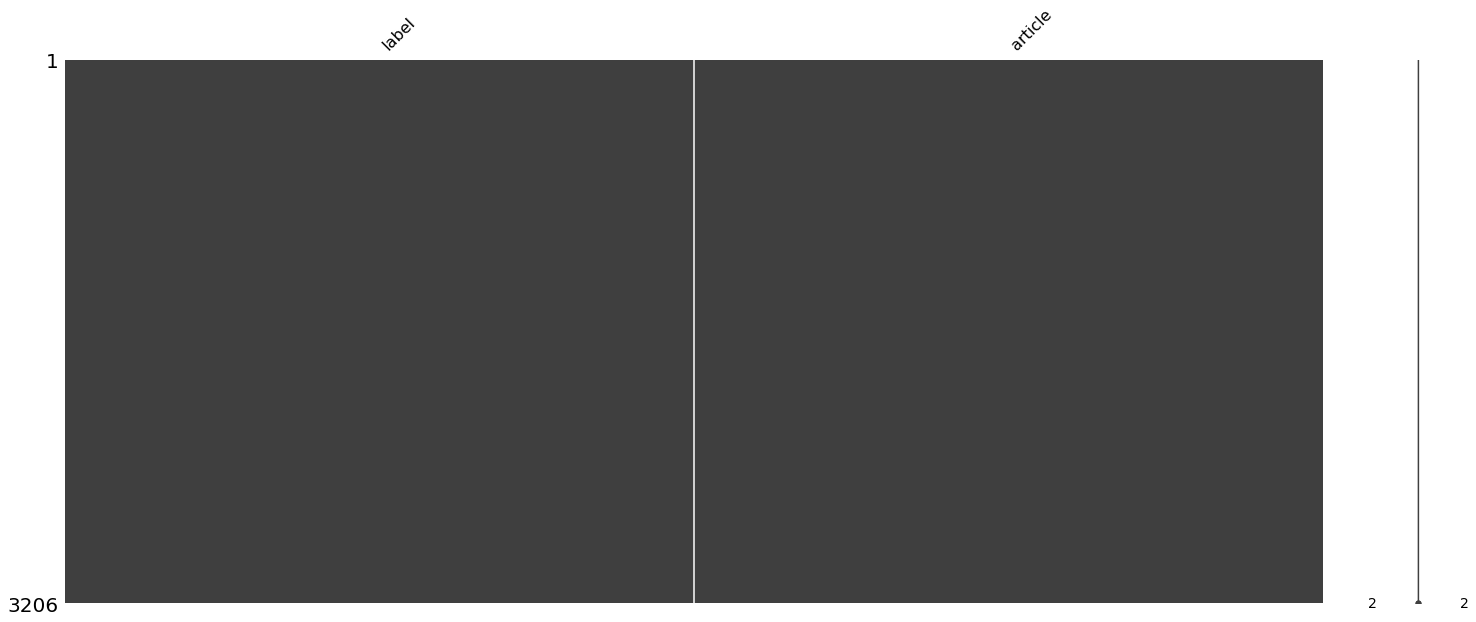

Missing: 0


In [84]:
missingno.matrix(df)
plt.show()
print("Missing: {}".format(df.isna().sum().sum()))

## Shuffling Dataset

In [85]:
from sklearn.utils import shuffle

df = shuffle(df).reset_index(drop=True)

In [86]:
df.head()

,label,article
0,1,Naligo ng batikos mula sa mga kababayan natin ...
1,1,"""There is a rule in the CPP-NPA against recrui..."
2,1,Lupa at bahay ang regalo ni Pangulong Duterte ...
3,1,Viral ngayon ang video ng pagkumpronta ng isan...
4,0,"Blocktimer si Willie, hindi station produced a..."


In [87]:
df.tail()

,label,article
3201,0,"Ayon sa website ng Irrawaddy magazine, kinonde..."
3202,1,Hindi maaring suspendihin ang isang batas na n...
3203,0,"SA totoo lang, nang-aagaw-eksena si Diego Loyz..."
3204,1,"Para kay Vice President Leni RObredo, kailanga..."
3205,0,Halimbawa na lamang nito ay ang komento ng mga...


In [88]:
df.loc[3201, 'article'] # 0

'Ayon sa website ng Irrawaddy magazine, kinondena ng mongheng Buddhist na si U Wirathu ang human rights rapporteur na si Yanghee Lee sa isang public rally noong nagkaraang Biyernes kontra sa boto sa UN General Assembly na nanawagang pagkalooban ng citizenship ang Rohingya Muslims sa bansa, kilala rin bilang Burma.'

In [89]:
df.loc[3202, 'article'] # 1

'Hindi maaring suspendihin ang isang batas na napirmahan na ni Pangulong Rodrigo Duterte. Ito ang reaksyon ni Sen. Richard Gordon sa pahayag ng Pangulo na sususpendihin niya ang implementasyon ng Motorcycle Crime Prevention Law o mas kilalang Doble Plaka Law dahil delikado ito para sa mga motorista at masyadong mataas ang multa na P50,000. Sinabi ni Gordon na napirmahan na ng pangulo ang batas kaya hindi na ito maaring suspendihin. "Hindi pwedeng suspendehin ang batas. Batas na, pinirmahan na niya \'yan e," ani Gordon. Iginiit din ni Gordon na dapat maipatupad ang batas dahil sa dumaraming reported crimes na sangkot ang mga riding-in-tandem. Dagdag ni Gordong na hindi na muna pwede ibaba ang multa base sa kagustuhan ng Pangulo. "Hindi pwede, batas na \'yan e. Pwede nating i-amend next year," dagdag ni Gordon. Ayon kay Gordon, sa gagawin niyang pakikipag-usap sa Pangulo hihikayatin niya itong ikunsidera ang kaniyang naging pahayag. "Conduction sticker okay na sa akin \'yun eh, puwede \'

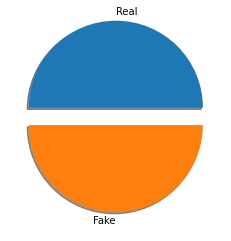

Real news count:  1603
Fake news count:  1603


In [90]:
# 1 == Fake and 0 == Real
real_news = len(df[df['label'] == 0])
fake_news = len(df[df['label'] == 1])
plt.pie([real_news, fake_news], labels=['Real', 'Fake'], explode = [0.2,0.0] , shadow=True)
plt.show()

print("Real news count: ", real_news)
print("Fake news count: ", fake_news)

# Data Preprocessing

## Converting text to lowercase

In [91]:
df['article'] = df['article'].apply(lambda txt: txt.lower())

In [92]:
df.head()

,label,article
0,1,naligo ng batikos mula sa mga kababayan natin ...
1,1,"""there is a rule in the cpp-npa against recrui..."
2,1,lupa at bahay ang regalo ni pangulong duterte ...
3,1,viral ngayon ang video ng pagkumpronta ng isan...
4,0,"blocktimer si willie, hindi station produced a..."


## Removing Punctuations

In [93]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [94]:
def remove_punctuation(txt):
  all_list = [char for char in txt if char not in string.punctuation]
  return ''.join(all_list)

In [95]:
df['article'] = df['article'].apply(remove_punctuation)

In [96]:
df.head()

,label,article
0,1,naligo ng batikos mula sa mga kababayan natin ...
1,1,there is a rule in the cppnpa against recruitm...
2,1,lupa at bahay ang regalo ni pangulong duterte ...
3,1,viral ngayon ang video ng pagkumpronta ng isan...
4,0,blocktimer si willie hindi station produced an...


## Removing stopwords

Stop words are the words in a stop list which are filtered out before or after processing of natural language data because they are insignificant. Examples of stop words in English are “a”, “the”, “is”, “are” and etc.

### English Stopwords

In [106]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

df['article'] = df['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,article
0,1,naligo ng batikos mula sa mga kababayan natin ...
1,1,rule cppnpa recruitment minors definitely cann...
2,1,lupa bahay ang regalo ni pangulong duterte kay...
3,1,viral ngayon ang video ng pagkumpronta ng isan...
4,0,blocktimer si willie hindi station produced an...


### Tagalog Stopwords

In [132]:
tl_stopwords = []
with open('stopwords-tl.txt') as topo_file:
    for line in topo_file:
        tl_stopwords.append(line.replace('\n', ''))
tl_stopwords.extend(['ba', 'eh', 'kasi', 'lang', 'mo', 'naman', 'opo', 'po', 'si', 'talaga', 'yung'])

In [133]:
print(tl_stopwords)

['akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'bababa', 'bago', 'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito', 'doon', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka', 'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang', 'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan', 'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod', 'lima', 'maaari', 'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin', 'napaka', 'narito', 'nasaan', 'ng', 'ngayon', 'ni', 'nila',

In [134]:
df['article'] = df['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tl_stopwords)]))
df.head()

,label,article
0,1,naligo batikos kababayan natin liberal party s...
1,1,rule cppnpa recruitment minors definitely cann...
2,1,lupa bahay regalo pangulong duterte kay cadet ...
3,1,viral video pagkumpronta pamilya service crew ...
4,0,blocktimer willie station produced show tila p...


## Visualizing Frequent Word Occurrency

In [135]:
from wordcloud import WordCloud

is_fake = df['label'] == 1
fake_data = df[is_fake]
real_data = df[~is_fake]

Fake News


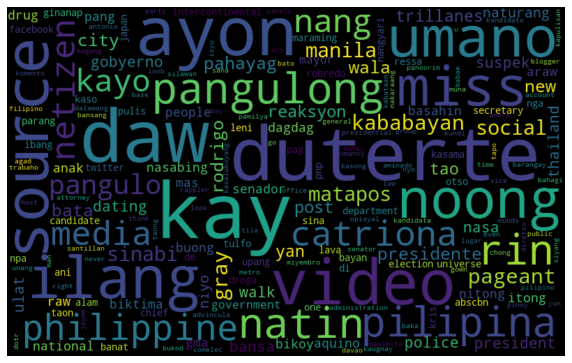

In [136]:
all_words = ' '.join([text for text in fake_data.article])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
print("Fake News")

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Real News


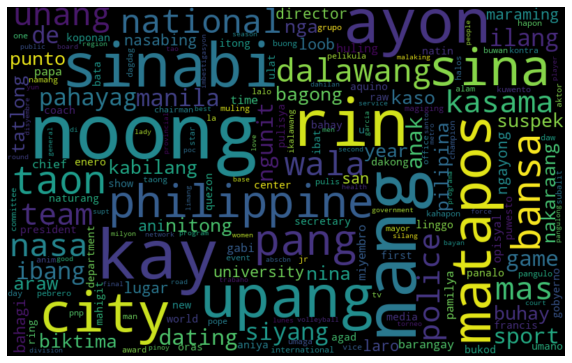

In [137]:
print("Real News")
all_words = ' '.join([text for text in real_data.article])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Most frequent words counter

In [138]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
  all_words = ' '.join([text for text in text[column_text]])
  token_phrase = token_space.tokenize(all_words)
  frequency = nltk.FreqDist(token_phrase)
  df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                  "Frequency": list(frequency.values())})
  df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
  plt.figure(figsize=(12,8))
  ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
  ax.set(ylabel = "Count")
  plt.xticks(rotation='vertical')
  plt.show()

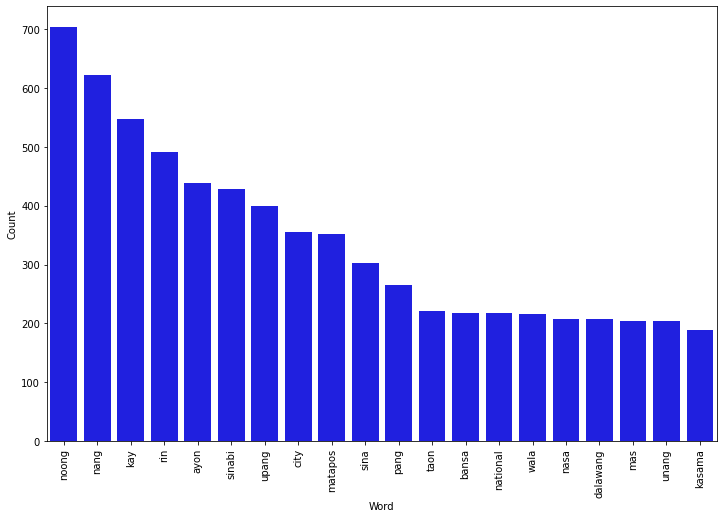

In [139]:
counter(df[df["label"] == 0], "article", 20)

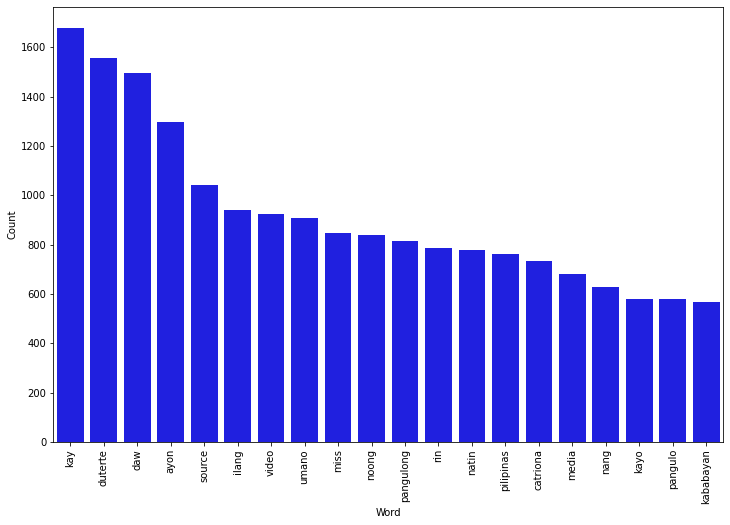

In [140]:
counter(df[df["label"] == 1], "article", 20)

# Model Development

## Splitting Data

In [143]:
X_train, X_test, y_train, y_test = train_test_split(df['article'], df['label'], test_size=0.2, random_state=42)

In [145]:
X_train.shape, y_train.shape

((2564,), (2564,))

In [147]:
X_test.shape, y_test.shape

((642,), (642,))

## Building Pipeline

In [185]:
pipeline = Pipeline([
                    ('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', DecisionTreeClassifier())
                    ])

criterion = ['gini', 'entropy']
max_depth = range(1,30)
splitter = ["best", "random"]
parameters = dict(model__criterion=criterion,
                  model__max_depth=max_depth,
                  model__splitter=splitter)

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
# grid_search.get_params().keys()
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 116 candidates, totalling 580 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('model', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(1, 30),
                         'model__splitter': ['best', 'random']},
             verbose=1)

In [186]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.926
Best parameters set:
	model__criterion: 'entropy'
	model__max_depth: 18
	model__splitter: 'random'


In [187]:
pipeline = Pipeline([
                    ('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 18, 
                                           splitter='random', 
                                           random_state=42))
                    ])

## Fitting the model

In [188]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=18,
                                        random_state=42, splitter='random'))])

## Predicting testing dataset

In [189]:
predictions = pipeline.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, predictions)*100,2)))

accuracy: 92.21%


In [190]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix, without normalization


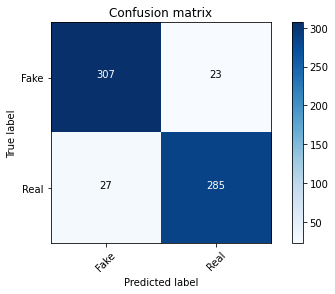

In [191]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])